
 Numeric features: ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'attendance_percentage', 'sleep_hours', 'exercise_frequency', 'mental_health_rating']
 Categorical features: ['gender', 'part_time_job', 'diet_quality', 'parental_education_level', 'internet_quality', 'extracurricular_participation']

 Linear Regression Performance:
MAE  : 4.1923
RMSE : 5.1510
R²   : 0.8965

 Top 10 Influential Features on Exam Score:
                  Feature  Coefficient
1     study_hours_per_day    14.144790
7    mental_health_rating     5.565088
2      social_media_hours    -3.129732
6      exercise_frequency     2.656671
3           netflix_hours    -2.531563
5             sleep_hours     2.421865
4   attendance_percentage     1.349632
13      diet_quality_Fair     0.502625
10           gender_Other     0.491633
14      diet_quality_Good    -0.455348


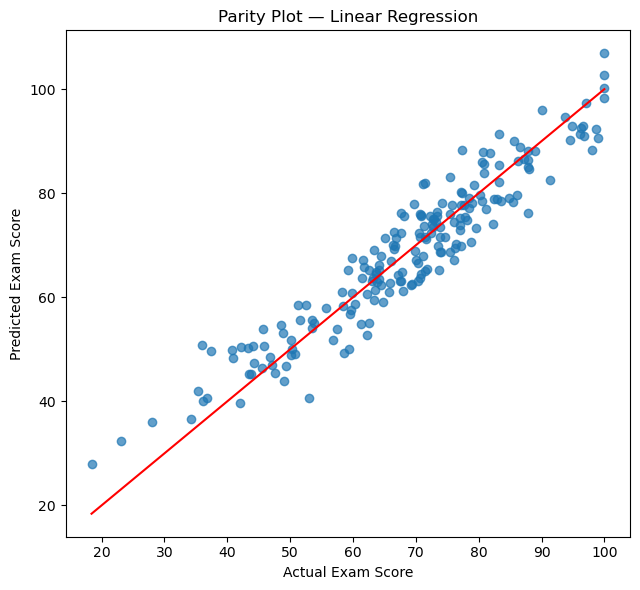

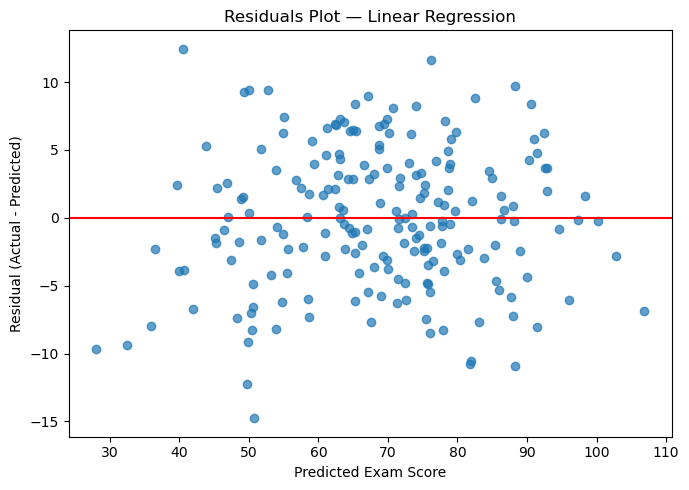

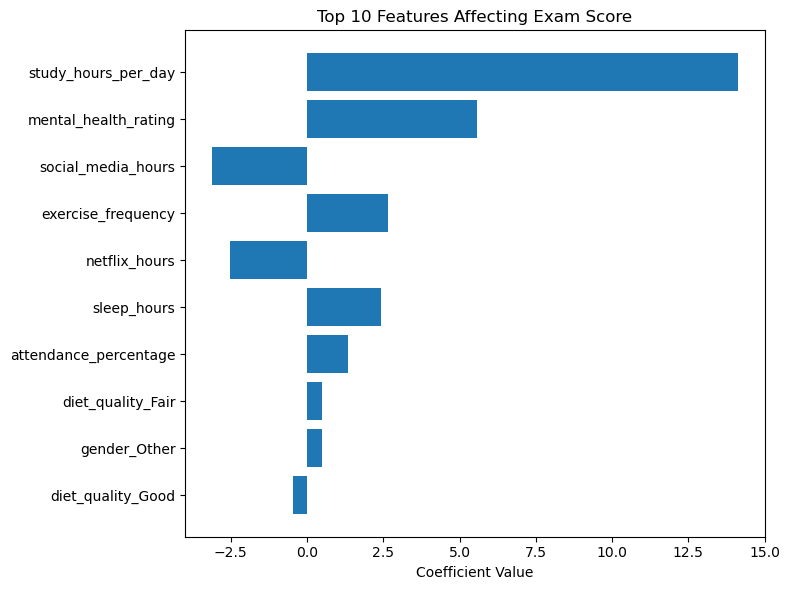

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

CSV_PATH = r"C:\Data\student_habits_performance.csv"   
TARGET = "exam_score"      # to predict exam performance
RANDOM_STATE = 42
TEST_SIZE = 0.2


#1) Load Data

df = pd.read_csv(CSV_PATH)

if TARGET not in df.columns:
    raise ValueError(f"TARGET '{TARGET}' not found in columns: {list(df.columns)}")

y = df[TARGET].astype(float)
X = df.drop(columns=[TARGET, "student_id"])  # drop ID since it's not predictive

# Identify column types
cat_cols = [c for c in X.columns if X[c].dtype == 'object' or str(X[c].dtype).startswith('category')]
num_cols = [c for c in X.columns if c not in cat_cols]

print(f"\n Numeric features: {num_cols}")
print(f" Categorical features: {cat_cols}")


#2) Split Data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)


#3) Preprocessing Pipelines

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # updated param
])

pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
], remainder="drop", verbose_feature_names_out=False)


#4) Model Pipeline

pipe = Pipeline([
    ("pre", pre),
    ("lr", LinearRegression())
])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)


#5) Metrics

mae = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)

print(f"\n Linear Regression Performance:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


#6) Feature Importance

feature_names = pipe.named_steps["pre"].get_feature_names_out()
coefficients = pipe.named_steps["lr"].coef_

importance = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("\n Top 10 Influential Features on Exam Score:")
print(importance.head(10))


#7) Visualization Functions

def parity_plot(y_true, y_pred, title): #mean predicted values with the actual (true) values
    plt.figure(figsize=(6.5, 6))
    plt.scatter(y_true, y_pred, alpha=0.7)
    mn, mx = np.min(y_true), np.max(y_true)
    plt.plot([mn, mx], [mn, mx], color="red")
    plt.xlabel("Actual Exam Score")
    plt.ylabel("Predicted Exam Score")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def residuals_plot(y_true, y_pred, title):   #mean check whether the model’s errors are random or biased
    res = y_true - y_pred
    plt.figure(figsize=(7, 5))
    plt.scatter(y_pred, res, alpha=0.7)
    plt.axhline(0, color="red")
    plt.xlabel("Predicted Exam Score")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def feature_importance_plot(importance_df, top_n=10):
    plt.figure(figsize=(8, 6))
    plt.barh(importance_df["Feature"][:top_n], importance_df["Coefficient"][:top_n])
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} Features Affecting Exam Score")
    plt.xlabel("Coefficient Value")
    plt.tight_layout()
    plt.show()


#8) Generate Plots

parity_plot(y_test, pred, "Parity Plot — Linear Regression")
residuals_plot(y_test, pred, "Residuals Plot — Linear Regression")
feature_importance_plot(importance, top_n=10)

ANN -> MAE: 4.3356 | RMSE: 5.3692 | R²: 0.8876


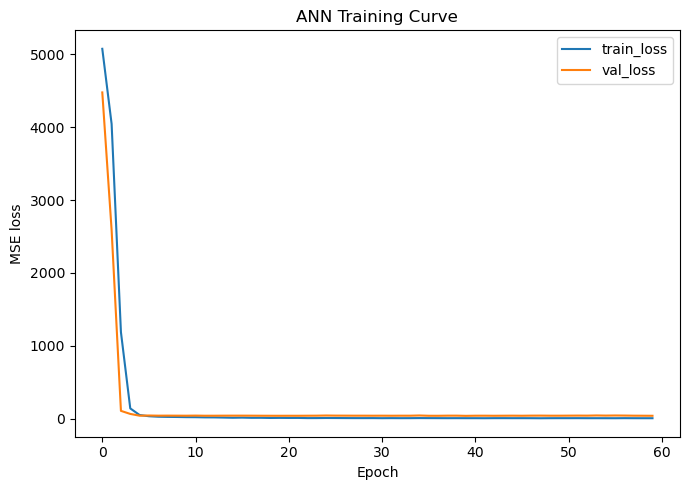

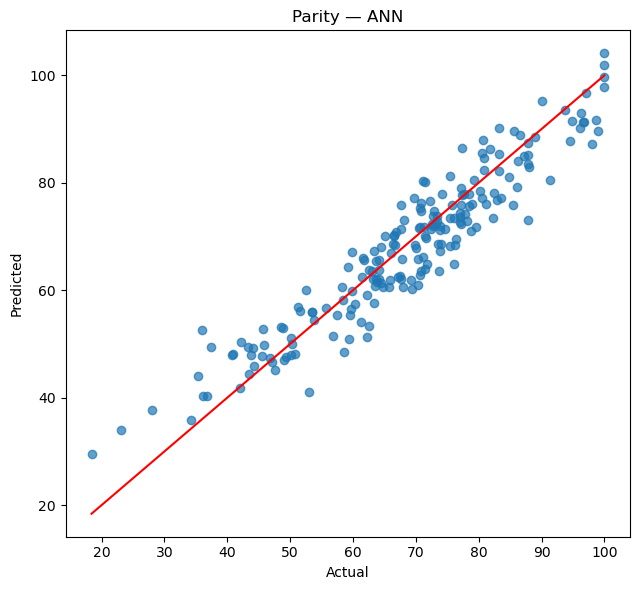

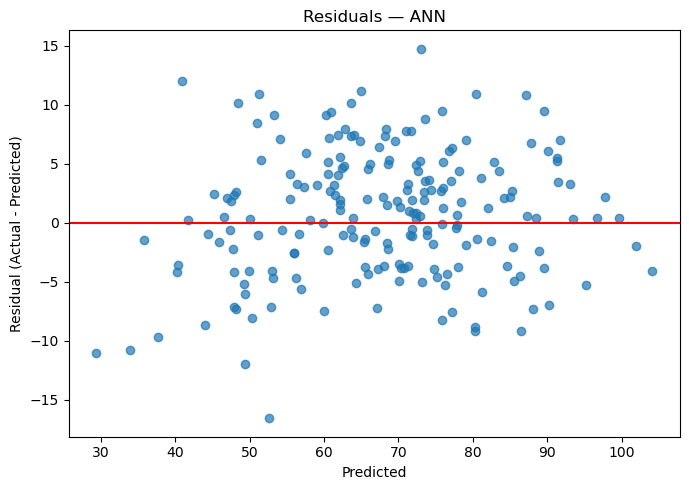

In [14]:
# ANN_regression


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Config
CSV_PATH = r"C:\Data\student_habits_performance.csv"
TARGET = "exam_score" 

RANDOM_STATE = 42
TEST_SIZE = 0.2
EPOCHS = 200
BATCH_SIZE = 32
PATIENCE = 20

# Helpers
def make_onehot():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def infer_target(df: pd.DataFrame):
    if TARGET is not None:
        if TARGET not in df.columns:
            raise ValueError(f"TARGET '{TARGET}' not found. Columns: {list(df.columns)}")
        return TARGET
    candidates = ["performance_score","score","final_score","average_score",
                  "target","y","grade","final_grade","exam_score","gpa"]
    cols_lower = {c.lower(): c for c in df.columns}
    for name in candidates:
        if name in cols_lower and pd.api.types.is_numeric_dtype(df[cols_lower[name]]):
            print(f"[INFO] Auto-selected target column: {cols_lower[name]}")
            return cols_lower[name]
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not numeric_cols:
        raise ValueError("No numeric column found for target auto-detection. Please set TARGET explicitly.")
    chosen = numeric_cols[-1]
    print(f"[INFO] Auto-selected target column (fallback): {chosen}")
    return chosen

def build_ann(input_dim: int):
    m = Sequential([
    Input(shape=(input_dim,)),
    Dense(128, activation='relu'),
    Dropout(0.10),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
    m.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return m

def parity_plot(y_true, y_pred, title):
    plt.figure(figsize=(6.5,6))
    plt.scatter(y_true, y_pred, alpha=0.7)
    mn, mx = np.min(y_true), np.max(y_true)
    plt.plot([mn, mx], [mn, mx], color="red")
    plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title(title)
    plt.tight_layout(); plt.show()

def residuals_plot(y_true, y_pred, title):
    res = y_true - y_pred
    plt.figure(figsize=(7,5))
    plt.scatter(y_pred, res, alpha=0.7)
    plt.axhline(0, color="red")
    plt.xlabel("Predicted"); plt.ylabel("Residual (Actual - Predicted)"); plt.title(title)
    plt.tight_layout(); plt.show()

# Load
df = pd.read_csv(CSV_PATH)
target_col = infer_target(df)

y = df[target_col].astype(float)
X = df.drop(columns=[target_col])

cat_cols = [c for c in X.columns if X[c].dtype == 'object' or str(X[c].dtype).startswith('category')]
num_cols = [c for c in X.columns if c not in cat_cols]

# Split & Preprocess
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])
cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", make_onehot())
])

pre = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

X_train_t = pre.fit_transform(X_train)
X_test_t  = pre.transform(X_test)

input_dim = X_train_t.shape[1]

# ANN Train
ann = build_ann(input_dim)
early = EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)

hist = ann.fit(
    X_train_t, y_train,
    validation_split=0.2,
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
    callbacks=[early]
)

pred = ann.predict(X_test_t, verbose=0).flatten()

# Metrics
mae  = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)
r2   = r2_score(y_test, pred)
print(f"ANN -> MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

# Plots
plt.figure(figsize=(7,5))
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("MSE loss"); plt.title("ANN Training Curve")
plt.legend(); plt.tight_layout(); plt.show()

parity_plot(y_test, pred, "Parity — ANN")
residuals_plot(y_test, pred, "Residuals — ANN")


Best LASSO params: {'alpha': 0.0001}
Best RIDGE params: {'alpha': 0.0001}
Best ELASTICNET params: {'alpha': 0.0001, 'l1_ratio': 0.9}

LASSO (L1) REGRESSION RESULTS
R²   : 0.8953
MAE  : 4.2235
RMSE : 5.1812


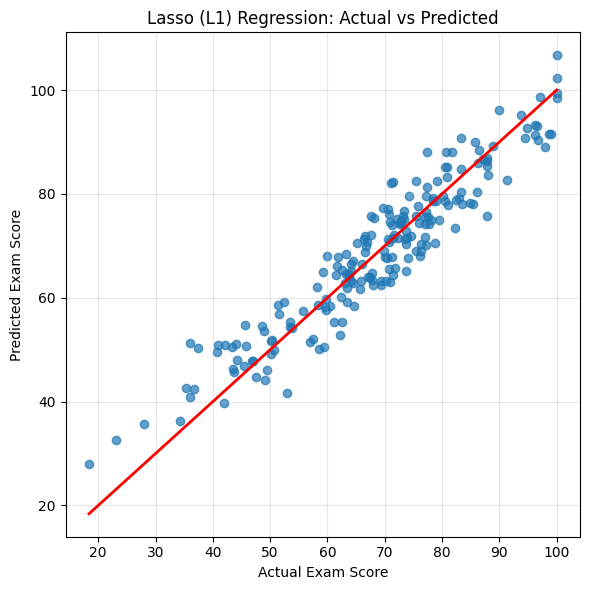

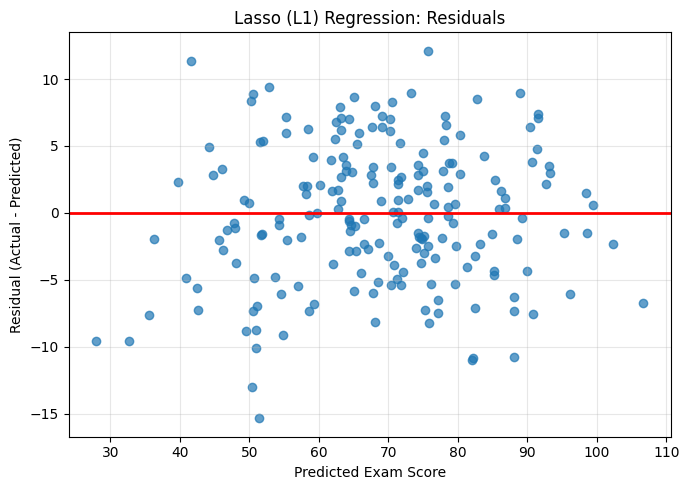


RIDGE (L2) REGRESSION RESULTS
R²   : 0.6694
MAE  : 7.0630
RMSE : 9.2073


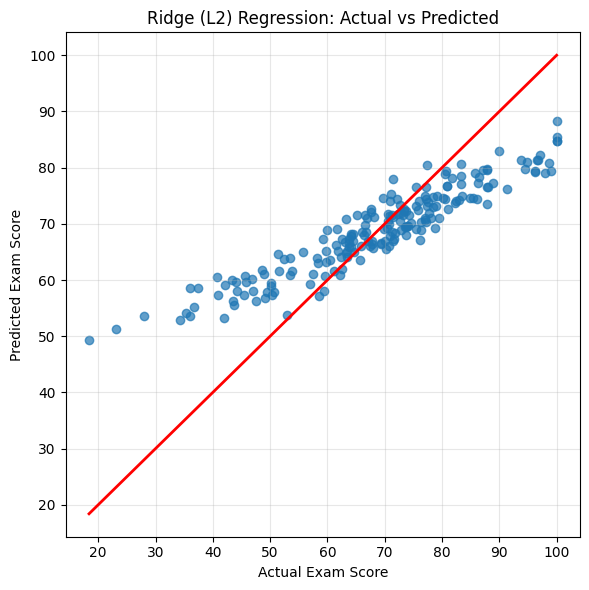

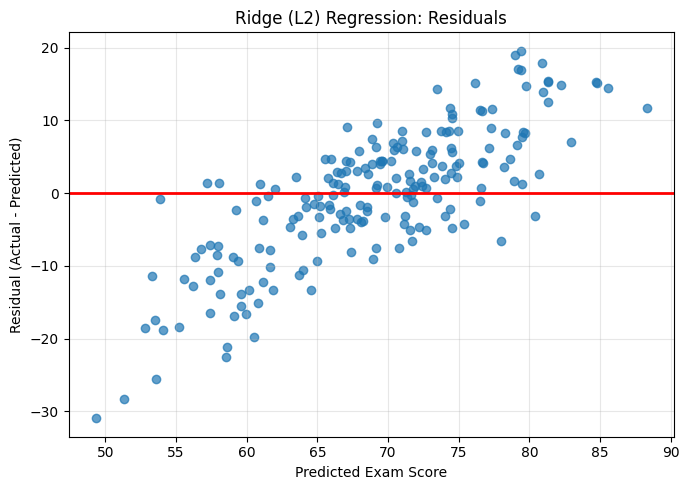


ELASTICNET REGRESSION RESULTS
R²   : 0.8953
MAE  : 4.2248
RMSE : 5.1824


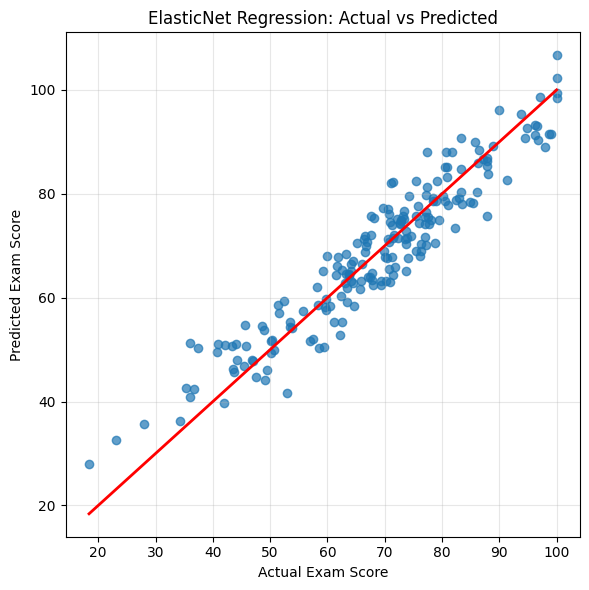

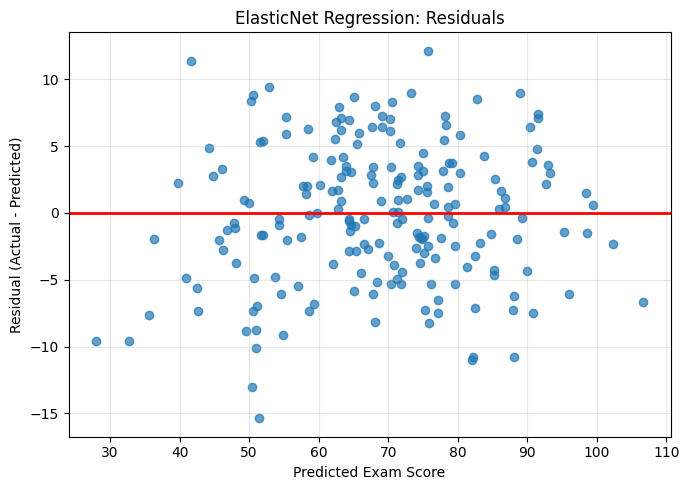


Model Coefficients (top 5 by |ElasticNet|):
                Feature      Lasso     Ridge  ElasticNet
1   study_hours_per_day  13.890126  7.540796   13.878398
7  mental_health_rating   5.665484  2.574711    5.663318
2    social_media_hours  -3.206512 -1.388905   -3.206111
5           sleep_hours   2.811587  0.924567    2.811120
3         netflix_hours  -2.675999 -1.219286   -2.675426

Test Metrics Summary
Lasso (L1)   -> MAE: 4.2235 | RMSE: 5.1812 | R²: 0.8953
Ridge (L2)   -> MAE: 7.0630 | RMSE: 9.2073 | R²: 0.6694
ElasticNet   -> MAE: 4.2248 | RMSE: 5.1824 | R²: 0.8953

Best model on TEST (by RMSE): Lasso (L1)


In [9]:
# STUDENT PERFORMANCE PREDICTION 
# 3Advance LR - LASSO, RIDGE & ELASTICNET (with GridSearchCV)

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Silence common optimization warnings to keep output tidy
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 1. Load Dataset
FILE = r"C:\Data\student_habits_performance.csv"
df = pd.read_csv(FILE)

# 2. Define Target & Features
target = "exam_score"
if target not in df.columns:
    raise ValueError(f"Target '{target}' not in columns: {list(df.columns)}")

X = df.drop(columns=[target])
y = df[target].astype(float)

# Convert non-numeric columns (like gender, etc.) to numeric
X = pd.get_dummies(X, drop_first=True)

# 3. Split Data (Train/Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 5. Helper Function for Evaluation & Plotting
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2   = r2_score(y_test, y_pred)
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\n{name.upper()} REGRESSION RESULTS")
    print(f"R²   : {r2:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")

    # Plot Actual vs Predicted (parity)
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    mn, mx = y_test.min(), y_test.max()
    plt.plot([mn, mx], [mn, mx], color='red', lw=2)
    plt.xlabel("Actual Exam Score")
    plt.ylabel("Predicted Exam Score")
    plt.title(f"{name} Regression: Actual vs Predicted")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Residuals plot
    residuals = y_test - y_pred
    plt.figure(figsize=(7, 5))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(0, color='red', lw=2)
    plt.xlabel("Predicted Exam Score")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title(f"{name} Regression: Residuals")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return mae, rmse, r2

# 6–8. Models with GridSearchCV
# Scoring: use R² for selection; set cv=5 and n_jobs=-1 for speed
# Increase max_iter for stability (especially ElasticNet / Lasso)
cv = 5
n_jobs = -1

# LASSO
lasso_param_grid = {
    "alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
}
lasso_grid = GridSearchCV(
    estimator=Lasso(max_iter=10000),
    param_grid=lasso_param_grid,
    scoring="r2",
    cv=cv,
    n_jobs=n_jobs,
    refit=True,
)
lasso_grid.fit(X_train_scaled, y_train)
best_lasso = lasso_grid.best_estimator_
print("Best LASSO params:", lasso_grid.best_params_)

# RIDGE
ridge_param_grid = {
    "alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
}
ridge_grid = GridSearchCV(
    estimator=Ridge(max_iter=10000),
    param_grid=ridge_param_grid,
    scoring="r2",
    cv=cv,
    n_jobs=n_jobs,
    refit=True,
)
ridge_grid.fit(X_train_scaled, y_train)
best_ridge = ridge_grid.best_estimator_
print("Best RIDGE params:", ridge_grid.best_params_)

# ELASTICNET
elastic_param_grid = {
    "alpha":    [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
    "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}
elastic_grid = GridSearchCV(
    estimator=ElasticNet(max_iter=10000, random_state=42),
    param_grid=elastic_param_grid,
    scoring="r2",
    cv=cv,
    n_jobs=n_jobs,
    refit=True,
)
elastic_grid.fit(X_train_scaled, y_train)
best_elastic = elastic_grid.best_estimator_
print("Best ELASTICNET params:", elastic_grid.best_params_)

# 9. Evaluate tuned models on TEST set
lasso_metrics   = evaluate_model("Lasso (L1)", best_lasso,   X_test_scaled, y_test)
ridge_metrics   = evaluate_model("Ridge (L2)", best_ridge,   X_test_scaled, y_test)
elastic_metrics = evaluate_model("ElasticNet", best_elastic, X_test_scaled, y_test)

# 10. Coefficient comparison (using tuned models)
coef_df = pd.DataFrame({
    "Feature":     X.columns,
    "Lasso":       best_lasso.coef_,
    "Ridge":       best_ridge.coef_,
    "ElasticNet":  best_elastic.coef_
})
print("\nModel Coefficients (top 5 by |ElasticNet|):")
print(coef_df.reindex(coef_df["ElasticNet"].abs().sort_values(ascending=False).index).head(5))

# 11. Compact summary table + best model by RMSE
results = {
    "Lasso (L1)":   lasso_metrics,      # (MAE, RMSE, R2)
    "Ridge (L2)":   ridge_metrics,
    "ElasticNet":   elastic_metrics,
}

print("\nTest Metrics Summary")
for name, (mae, rmse, r2) in results.items():
    print(f"{name:<12} -> MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

best_by_rmse = min(results.items(), key=lambda kv: kv[1][1])[0]
print(f"\nBest model on TEST (by RMSE): {best_by_rmse}")


C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Metrics 
Linear Regression   -> MAE: 4.2489 | RMSE: 5.2191 | R²: 0.8938
ANN (Deep Learning) -> MAE: 4.3813 | RMSE: 5.4098 | R²: 0.8859
Hybrid (LR+ANN)     -> MAE: 4.2499 | RMSE: 5.2210 | R²: 0.8937
Chosen alpha (weight on LR) for hybrid: 0.95


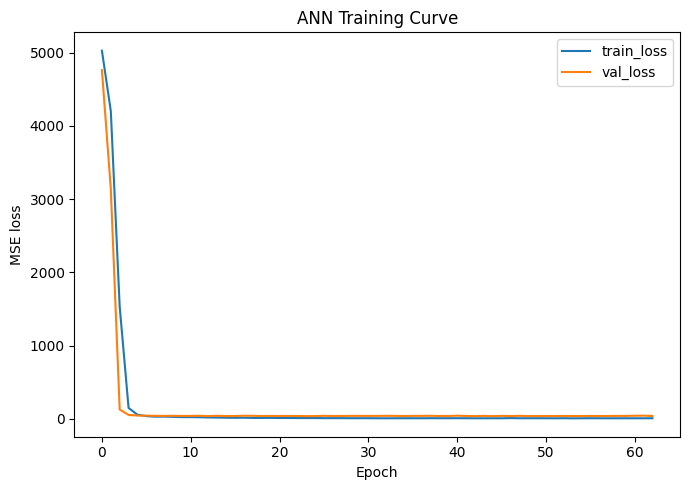

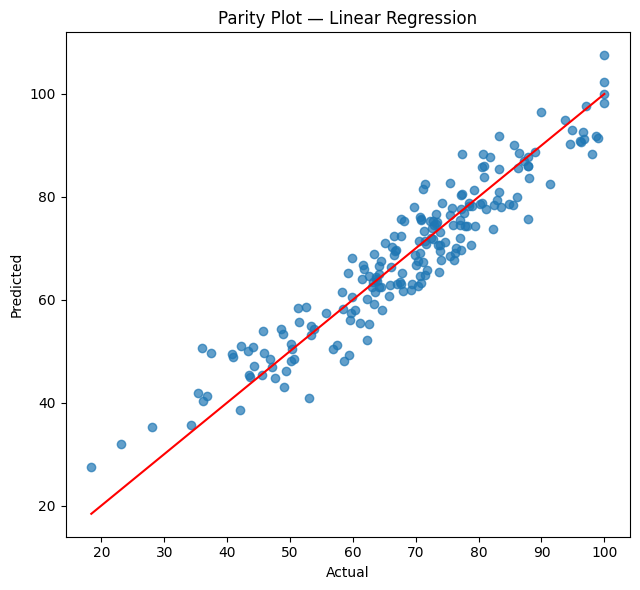

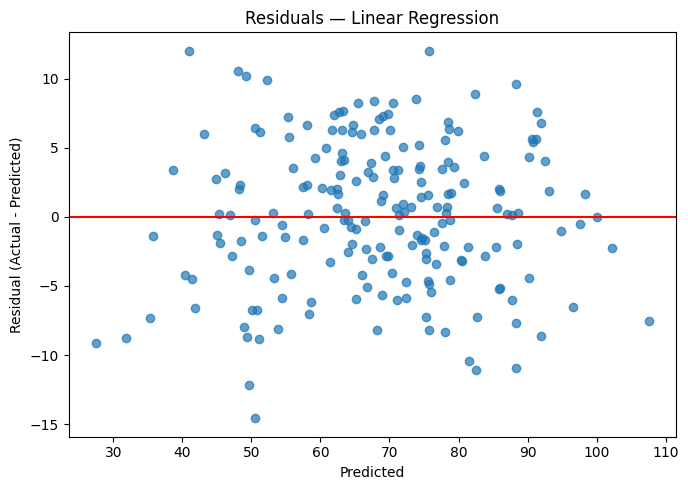

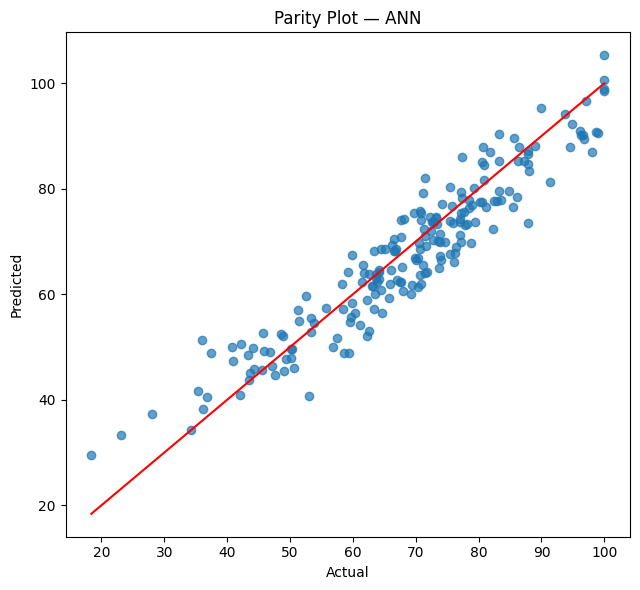

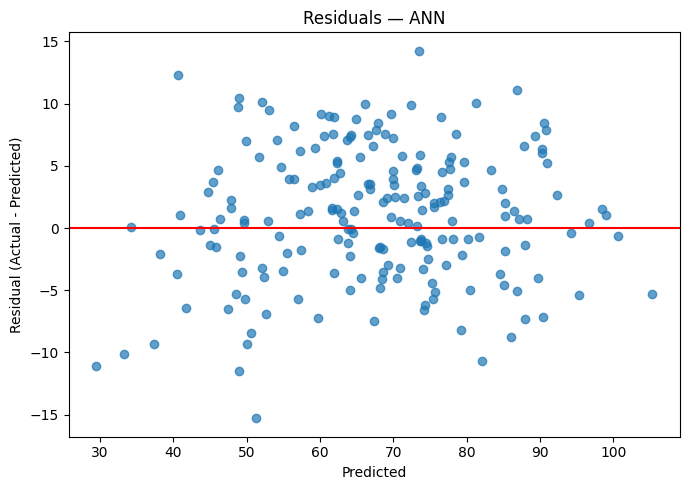

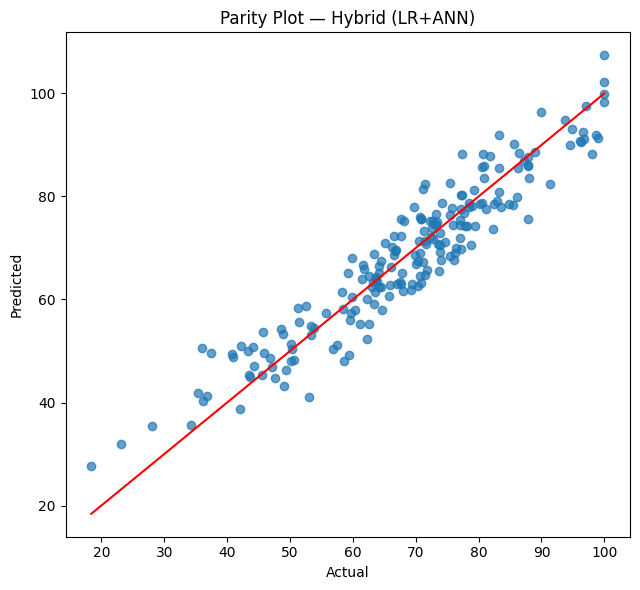

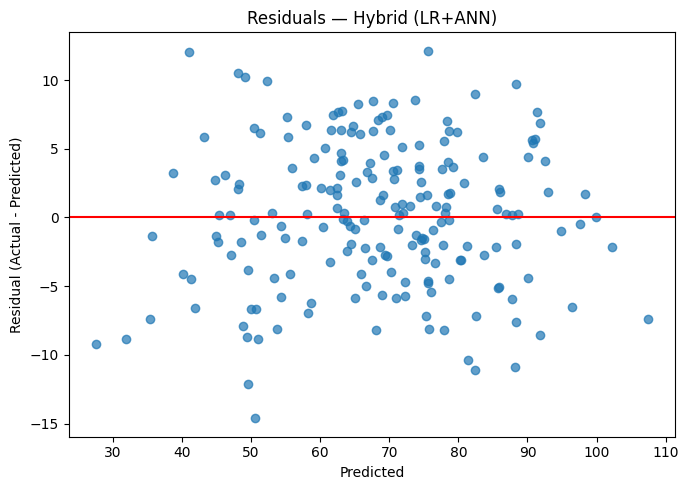

In [7]:
# Regression: Traditional (LR), Deep (ANN), Hybrid (LR+ANN)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1) Config

CSV_PATH = r"C:\Data\student_habits_performance.csv" 
TARGET   = "exam_score"                

RANDOM_STATE = 42            #random seed to make sure results are reproducible
TEST_SIZE    = 0.2           #20% of the dataset will be set aside as a test set
VAL_SIZE     = 0.2           #20% of the training data will be used as a validation set
                             #validation split *from the training portion* (for hybrid weight) 
EPOCHS       = 200           #loop 200 times
BATCH_SIZE   = 32        
PATIENCE     = 20            #early stopping (to prevent overfitting)

# 2) Load data
df = pd.read_csv(CSV_PATH)

if TARGET not in df.columns:
    raise ValueError(f"TARGET column '{TARGET}' not found. Columns: {list(df.columns)}")

# Separate features/target
y = df[TARGET].astype(float)
X = df.drop(columns=[TARGET])

# Identify feature types
cat_cols = [c for c in X.columns if X[c].dtype == 'object' or str(X[c].dtype).startswith('category')]  #Loops through all columns in dataset
num_cols = [c for c in X.columns if c not in cat_cols]  #takes all columns in X that are not in cat_cols

# 3) Train/Validation/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# We'll carve out a validation set from the training set for tuning the hybrid weight
X_fit, X_val, y_fit, y_val = train_test_split(
    X_train, y_train, test_size=VAL_SIZE, random_state=RANDOM_STATE
)
#tuning means adjusting the model’s parameters or settings to make it perform better to reduce errors and improve accuracy.

# 4) Preprocessing
# change categorical to numerical
# OneHotEncoder -> dense output so we can feed it to both LR and ANN easily
num_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),  #fills missing numeric values with the median of that column.
    ("scale", StandardScaler())                    #standardizes the data by subtracting the mean and dividing by the standard deviation.
])

cat_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),              #fills missing text values with the most frequent value in that column.
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  #converts categorical labels into binary columns like 0 and 1
])

preprocessor = ColumnTransformer(    #applies different preprocessing steps to different column types
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",               #drops any columns not listed
    verbose_feature_names_out=False #keeps simpler feature names after transformation
)

# Fit preprocessor on training subset (X_fit) to avoid peeking at validation/test
preprocessor.fit(X_fit)

# Transform splits to dense arrays
X_fit_t = preprocessor.transform(X_fit)
X_val_t = preprocessor.transform(X_val)
X_train_t = preprocessor.transform(X_train)   # (fit+val) used for final refits if desired
X_test_t = preprocessor.transform(X_test)

input_dim = X_train_t.shape[1]

# 5) Traditional: Linear Regression
lr = LinearRegression()
lr.fit(X_fit_t, y_fit)

lr_val_pred  = lr.predict(X_val_t) #make predictions for validation and test sets
lr_test_pred = lr.predict(X_test_t)

# 6) Deep Learning: ANN (Artificial Neural Network)
def build_ann(input_dim: int):   #the number of features in your input data
    model = Sequential([         #means the model is built layer-by-layer
        Dense(128, activation="relu", input_shape=(input_dim,)),  #dence means fully connected layer, defines how many input features go into the network.
        Dropout(0.10),
        Dense(64, activation="relu"),   #relu = Rectified linear unit, helps the model learn non-linear patterns.
        Dense(32, activation="relu"),   #activation function that helps the model learn complex patterns by keeping +value and turning -1 to 0
        Dense(1)  # regression output layer with 1 neuron
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"]) #daptive gradient method ,Mean Squared Error, Mean Absolute Error
    return model

ann = build_ann(input_dim)   #builds the model using the given number of input features
early_stop = EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)  #stops training early if validation loss stops improving
                                                                                              #patience = number of epochs to wait before stopping
history = ann.fit(
    X_fit_t, y_fit,                            #training data
    validation_data=(X_val_t, y_val),          #separate data for validation during training
    epochs=EPOCHS,                             #max number of times the model sees all the training data
    batch_size=BATCH_SIZE,                     #how many samples per update step
    verbose=0,                                 #hides training logs
    callbacks=[early_stop]                     #applies early stopping automatically
)

#make predictions for validation and test sets
ann_val_pred  = ann.predict(X_val_t, verbose=0).flatten()  #flatten mean converts 2D output arrays to 1D array
ann_test_pred = ann.predict(X_test_t, verbose=0).flatten()

# 7) Hybrid: optimize blend weight alpha on validation set
# hybrid_pred = alpha * lr_pred + (1 - alpha) * ann_pred
alphas = np.linspace(0, 1, 101)    #each value of alpha represents how much weight to give to the LR model, generate 101 valus between 0 and 1
best_alpha, best_mse = None, np.inf #means infinity
for a in alphas:  #loop
    blend = a * lr_val_pred + (1 - a) * ann_val_pred
    mse = mean_squared_error(y_val, blend)
    if mse < best_mse:  #if the current blend’s MSE is smaller (better) than the previous best one
        best_mse, best_alpha = mse, a

hyb_test_pred = best_alpha * lr_test_pred + (1 - best_alpha) * ann_test_pred

# 8) Metrics helper

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    # Version-safe RMSE (old sklearn lacks `squared` kwarg)
    try:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2  = r2_score(y_true, y_pred)
    return mae, rmse, r2

lr_mae,  lr_rmse,  lr_r2  = metrics(y_test, lr_test_pred)
ann_mae, ann_rmse, ann_r2 = metrics(y_test, ann_test_pred)
hyb_mae, hyb_rmse, hyb_r2 = metrics(y_test, hyb_test_pred)

print("Test Metrics ")
print(f"Linear Regression   -> MAE: {lr_mae:.4f} | RMSE: {lr_rmse:.4f} | R²: {lr_r2:.4f}")
print(f"ANN (Deep Learning) -> MAE: {ann_mae:.4f} | RMSE: {ann_rmse:.4f} | R²: {ann_r2:.4f}")
print(f"Hybrid (LR+ANN)     -> MAE: {hyb_mae:.4f} | RMSE: {hyb_rmse:.4f} | R²: {hyb_r2:.4f}")
print(f"Chosen alpha (weight on LR) for hybrid: {best_alpha:.2f}")

# 9) Plots
# 9a. ANN training curve
plt.figure(figsize=(7,5))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")       #number of training iteration
plt.ylabel("MSE loss")    #error between predicted and actual values, measured by Mean
plt.title("ANN Training Curve")
plt.legend()
plt.tight_layout()
plt.show()

# parity plot =#mean predicted values with the actual (true) values
def parity_plot(y_true, y_pred, title):
    plt.figure(figsize=(6.5,6))
    plt.scatter(y_true, y_pred, alpha=0.7)
    mn, mx = np.min(y_true), np.max(y_true)
    plt.plot([mn, mx], [mn, mx], color="red")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# residuals plot    =mean check whether the model’s errors are random or biased
def residuals_plot(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(7,5))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(0, color='red')
    plt.xlabel("Predicted")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Parity & residuals for all three
parity_plot(y_test, lr_test_pred,  "Parity Plot — Linear Regression")
residuals_plot(y_test, lr_test_pred, "Residuals — Linear Regression")

parity_plot(y_test, ann_test_pred, "Parity Plot — ANN")
residuals_plot(y_test, ann_test_pred, "Residuals — ANN")

parity_plot(y_test, hyb_test_pred, "Parity Plot — Hybrid (LR+ANN)")
residuals_plot(y_test, hyb_test_pred, "Residuals — Hybrid (LR+ANN)")


Best Ridge Parameter: {'alpha': 1}


C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Metrics 
Ridge Regression       -> MAE: 4.2493 | RMSE: 5.2196 | R²: 0.8938
ANN (Deep Learning)    -> MAE: 4.3488 | RMSE: 5.4098 | R²: 0.8859
Hybrid (Ridge + ANN)   -> MAE: 4.2493 | RMSE: 5.2196 | R²: 0.8938
Chosen alpha (weight on Ridge) for hybrid: 1.00


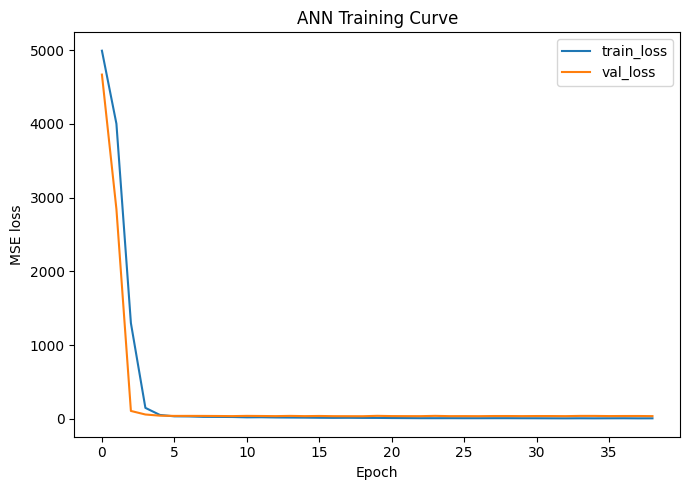

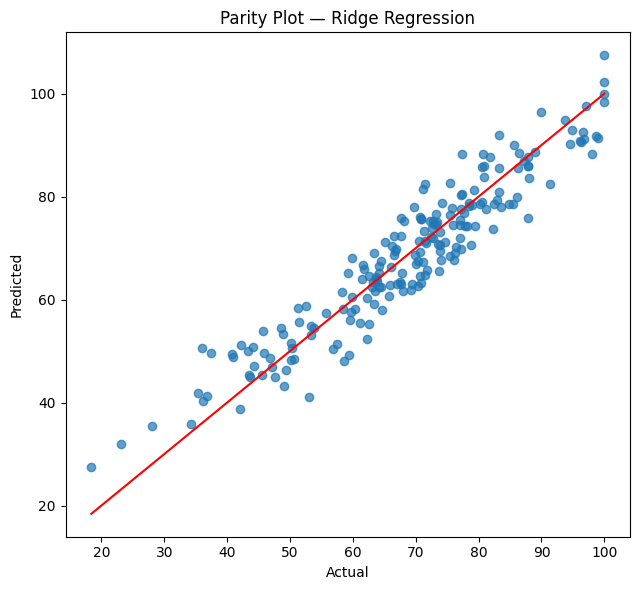

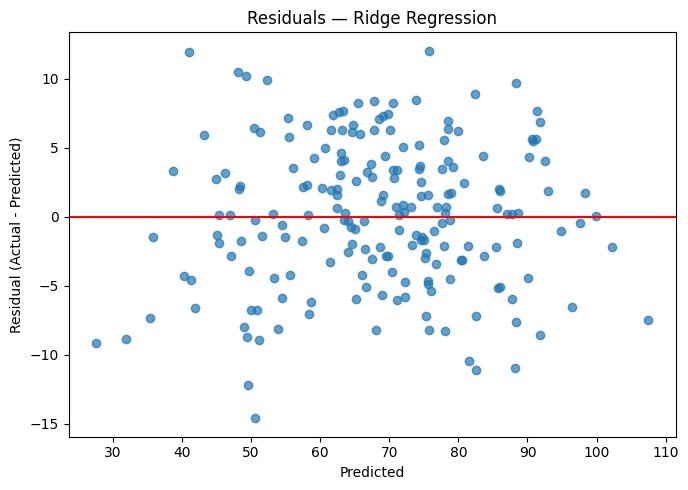

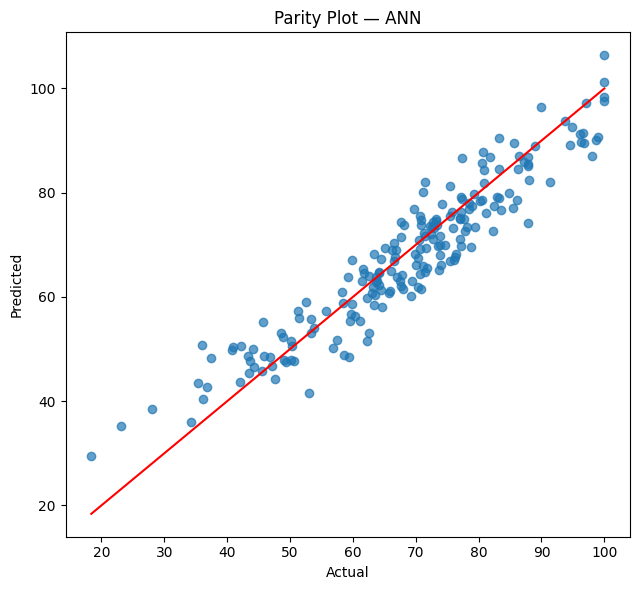

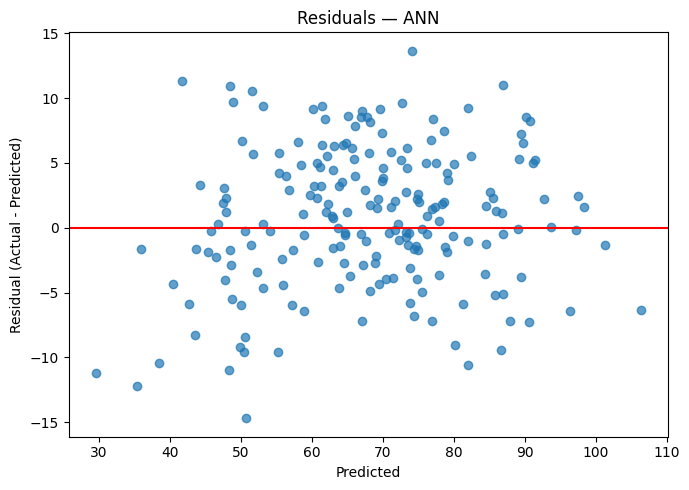

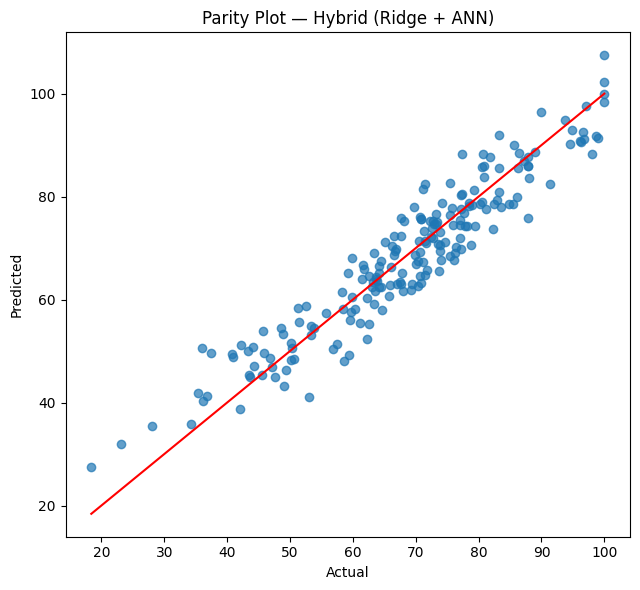

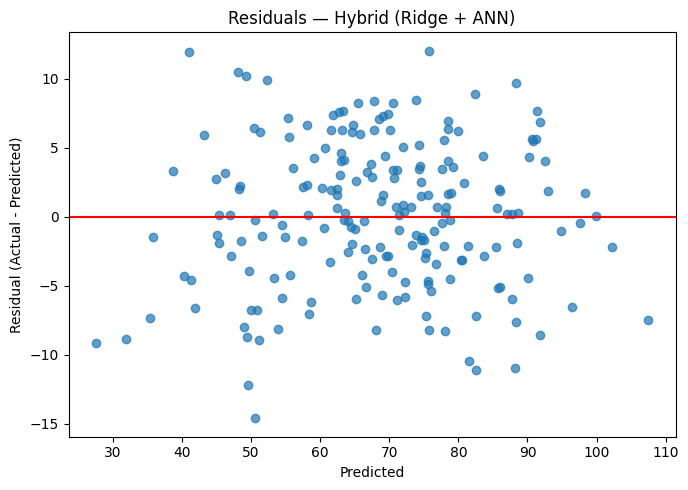

In [1]:
# Regression: Traditional (Ridge), Deep (ANN), Hybrid (Ridge + ANN)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1) Config

CSV_PATH = r"C:\Data\student_habits_performance.csv" 
TARGET   = "exam_score"                

RANDOM_STATE = 42            #random seed to make sure results are reproducible
TEST_SIZE    = 0.2           #20% of the dataset will be set aside as a test set
VAL_SIZE     = 0.2           #20% of the training data will be used as a validation set
                             #validation split *from the training portion* (for hybrid weight) 
EPOCHS       = 200           #loop 200 times
BATCH_SIZE   = 32        
PATIENCE     = 20            #early stopping (to prevent overfitting)

# 2) Load data
df = pd.read_csv(CSV_PATH)

if TARGET not in df.columns:
    raise ValueError(f"TARGET column '{TARGET}' not found. Columns: {list(df.columns)}")

# Separate features/target
y = df[TARGET].astype(float)
X = df.drop(columns=[TARGET])

# Identify feature types
cat_cols = [c for c in X.columns if X[c].dtype == 'object' or str(X[c].dtype).startswith('category')]  #Loops through all columns in dataset
num_cols = [c for c in X.columns if c not in cat_cols]  #takes all columns in X that are not in cat_cols

# 3) Train/Validation/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# We'll carve out a validation set from the training set for tuning the hybrid weight
X_fit, X_val, y_fit, y_val = train_test_split(
    X_train, y_train, test_size=VAL_SIZE, random_state=RANDOM_STATE
)
#tuning means adjusting the model’s parameters or settings to make it perform better to reduce errors and improve accuracy.

# 4) Preprocessing
# change categorical to numerical
# OneHotEncoder -> dense output so we can feed it to both Ridge and ANN easily
num_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),  #fills missing numeric values with the median of that column.
    ("scale", StandardScaler())                    #standardizes the data by subtracting the mean and dividing by the standard deviation.
])

cat_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),              #fills missing text values with the most frequent value in that column.
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  #converts categorical labels into binary columns like 0 and 1
])

preprocessor = ColumnTransformer(    #applies different preprocessing steps to different column types
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",               #drops any columns not listed
    verbose_feature_names_out=False #keeps simpler feature names after transformation
)

# Fit preprocessor on training subset (X_fit) to avoid peeking at validation/test
preprocessor.fit(X_fit)

# Transform splits to dense arrays
X_fit_t = preprocessor.transform(X_fit)
X_val_t = preprocessor.transform(X_val)
X_train_t = preprocessor.transform(X_train)   # (fit+val) used for final refits if desired
X_test_t = preprocessor.transform(X_test)

input_dim = X_train_t.shape[1]

# 5) Traditional: Ridge Regression
# Ridge Regression applies L2 regularization to reduce overfitting by shrinking coefficients smoothly.
# It is especially useful when predictors are correlated (e.g., study hours and attendance).

param_grid = {
    "alpha": [0.001, 0.01, 0.1, 1, 10, 100]  #controls the overall strength of the regularization
}

ridge = Ridge(max_iter=5000, random_state=RANDOM_STATE)
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring="r2", n_jobs=-1)  #finds the best alpha value
grid_search.fit(X_fit_t, y_fit)

best_ridge = grid_search.best_estimator_
print(f"Best Ridge Parameter: {grid_search.best_params_}")

#make predictions for validation and test sets
ridge_val_pred  = best_ridge.predict(X_val_t) 
ridge_test_pred = best_ridge.predict(X_test_t)

# 6) Deep Learning: ANN (Artificial Neural Network)
def build_ann(input_dim: int):   #the number of features in your input data
    model = Sequential([         #means the model is built layer-by-layer
        Dense(128, activation="relu", input_shape=(input_dim,)),  #dense means fully connected layer, defines how many input features go into the network.
        Dropout(0.10),
        Dense(64, activation="relu"),   #relu = Rectified Linear Unit, helps the model learn non-linear patterns.
        Dense(32, activation="relu"),   #activation function that helps the model learn complex patterns by keeping +value and turning -value to 0
        Dense(1)  # regression output layer with 1 neuron
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"]) #adam = adaptive gradient method, mse = Mean Squared Error, mae = Mean Absolute Error
    return model

ann = build_ann(input_dim)   #builds the model using the given number of input features
early_stop = EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)  #stops training early if validation loss stops improving
                                                                                              #patience = number of epochs to wait before stopping
history = ann.fit(
    X_fit_t, y_fit,                            #training data
    validation_data=(X_val_t, y_val),          #separate data for validation during training
    epochs=EPOCHS,                             #max number of times the model sees all the training data
    batch_size=BATCH_SIZE,                     #how many samples per update step
    verbose=0,                                 #hides training logs
    callbacks=[early_stop]                     #applies early stopping automatically
)

#make predictions for validation and test sets
ann_val_pred  = ann.predict(X_val_t, verbose=0).flatten()  #flatten converts 2D output arrays to 1D array
ann_test_pred = ann.predict(X_test_t, verbose=0).flatten()

# 7) Hybrid: optimize blend weight alpha on validation set
# hybrid_pred = alpha * Ridge_pred + (1 - alpha) * ann_pred
alphas = np.linspace(0, 1, 101)    #each value of alpha represents how much weight to give to the Ridge model, generate 101 values between 0 and 1
best_alpha, best_mse = None, np.inf #means infinity
for a in alphas:  #loop
    blend = a * ridge_val_pred + (1 - a) * ann_val_pred
    mse = mean_squared_error(y_val, blend)
    if mse < best_mse:  #if the current blend’s MSE is smaller (better) than the previous best one
        best_mse, best_alpha = mse, a

hyb_test_pred = best_alpha * ridge_test_pred + (1 - best_alpha) * ann_test_pred

# 8) Metrics helper

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    # Version-safe RMSE (old sklearn lacks `squared` kwarg)
    try:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2  = r2_score(y_true, y_pred)
    return mae, rmse, r2

ridge_mae,  ridge_rmse,  ridge_r2  = metrics(y_test, ridge_test_pred)
ann_mae, ann_rmse, ann_r2 = metrics(y_test, ann_test_pred)
hyb_mae, hyb_rmse, hyb_r2 = metrics(y_test, hyb_test_pred)

print("Test Metrics ")
print(f"Ridge Regression       -> MAE: {ridge_mae:.4f} | RMSE: {ridge_rmse:.4f} | R²: {ridge_r2:.4f}")
print(f"ANN (Deep Learning)    -> MAE: {ann_mae:.4f} | RMSE: {ann_rmse:.4f} | R²: {ann_r2:.4f}")
print(f"Hybrid (Ridge + ANN)   -> MAE: {hyb_mae:.4f} | RMSE: {hyb_rmse:.4f} | R²: {hyb_r2:.4f}")
print(f"Chosen alpha (weight on Ridge) for hybrid: {best_alpha:.2f}")

# 9) Plots
# 9a. ANN training curve
plt.figure(figsize=(7,5))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")       #number of training iteration
plt.ylabel("MSE loss")    #error between predicted and actual values, measured by Mean
plt.title("ANN Training Curve")
plt.legend()
plt.tight_layout()
plt.show()

# parity plot =mean predicted values with the actual (true) values
def parity_plot(y_true, y_pred, title):
    plt.figure(figsize=(6.5,6))
    plt.scatter(y_true, y_pred, alpha=0.7)
    mn, mx = np.min(y_true), np.max(y_true)
    plt.plot([mn, mx], [mn, mx], color="red")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# residuals plot = check whether the model’s errors are random or biased
def residuals_plot(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(7,5))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(0, color='red')
    plt.xlabel("Predicted")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Parity & residuals for all three
parity_plot(y_test, ridge_test_pred,  "Parity Plot — Ridge Regression")
residuals_plot(y_test, ridge_test_pred, "Residuals — Ridge Regression")

parity_plot(y_test, ann_test_pred, "Parity Plot — ANN")
residuals_plot(y_test, ann_test_pred, "Residuals — ANN")

parity_plot(y_test, hyb_test_pred, "Parity Plot — Hybrid (Ridge + ANN)")
residuals_plot(y_test, hyb_test_pred, "Residuals — Hybrid (Ridge + ANN)")


In [2]:
# =============================
# FEATURE ENGINEERING
# Student Habits vs Performance
# =============================

import pandas as pd

# 1) Load the original dataset
# (Make sure this path points to your raw dataset file)
FILE_PATH = r"C:\Data\student_habits_performance.csv"
df = pd.read_csv(FILE_PATH)

# 2) Create new engineered features
# -------------------------------

# leisure_hours = combination of social media and Netflix hours
df["leisure_hours"] = df["social_media_hours"] + df["netflix_hours"]

# study_sleep_ratio = ratio of study hours per day to sleep hours
# helps see if students are balancing work and rest
df["study_sleep_ratio"] = df["study_hours_per_day"] / df["sleep_hours"]

# sleep_deficit = how much less than 8 hours the student sleeps
# clip(lower=0) ensures that negative values (more than 8 hours) become 0
df["sleep_deficit"] = (8 - df["sleep_hours"]).clip(lower=0)

# attendance_x_study = attendance percentage multiplied by study hours
# shows combined academic effort
df["attendance_x_study"] = df["attendance_percentage"] * df["study_hours_per_day"]

# 3) Preview the new engineered columns
print("Preview of new engineered features:\n")
print(df[["leisure_hours", "study_sleep_ratio", "sleep_deficit", "attendance_x_study"]].head())

# 4) Save the new dataset to a CSV file for later use in training
OUTPUT_PATH = r"C:\Data\student_habits_engineered.csv"
df.to_csv(OUTPUT_PATH, index=False)



Preview of new engineered features:

   leisure_hours  study_sleep_ratio  sleep_deficit  attendance_x_study
0            2.3           0.000000            0.0                0.00
1            5.1           1.500000            3.4              671.37
2            4.4           0.175000            0.0              132.72
3            4.9           0.108696            0.0               71.00
4            4.9           1.020408            3.1              454.50
